#  A/B Testing - Cookie Cats

- [Introduction](#Introduction)
- [Data Loading](#Data-Loading)
- [Analysis](#Analysis)
- [A/B Testing](#A-B-Testing)
- [Conclusions](#Conclusions)


## Introduction

This dataset includes A/B test results of Cookie Cats App: the purpose is to analyse what happens when the first gate in the game is moved from level 30 to level 40. When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

### Aim

The aim is to study a valid alternative to keep players active for a longer time.


### Hyphothesis

It is assumed that by positioning the gate at the level 40, the players will find the game easier and keep playing for a longer time. This will lead to a prolonged users' traffic and and bigger revenue from the game.

Before proceeding further, the following hypotheses are set for the experiment:  

$$\text{Null hypothesis:}\quad H_0 = H_1$$  

$$\text{Alternative hypothesis:}\quad H_0 \neq H_1$$ 

The null hypothesis implies that there is no difference between the two version of the game, hence the samples are indenpendent from each others. Viceversa, the second hypothesis refers to the scenario when the samples are dependent from each other.

## Data Loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, chi2_contingency, bootstrap

In [3]:
# Read the CSV file
cookie = pd.read_csv("cookie_cats.csv")

In [4]:
# Display the first few rows of each DataFrame
cookie.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [5]:
# Clean the data by removing rows with missing values
cookie.size
nulls = cookie.isnull().sum()
nan = cookie.isna().sum()
if nulls.sum() == 0 & nan.sum() == 0:
    print("No missing values in the dataset.")
else:
    sum = nulls.sum() + nan.sum()
    print(f"Total number of missing values in the dataset: {sum}")
    cookie = cookie.dropna()
    print("Missing values have been removed.")

No missing values in the dataset.


## Analysis


The metrics in this case have been already selected as the test was runned, the table is only collecting the reults.

Despite not a fully test needs to be taken, the metrics and the results have to be reviewed.

It is useful to review the structure of the DataSet, like size, statistical features and variable distributions

In [6]:
# Display the information about the DataFrame
cookie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [18]:
# Display the summary statistics of the DataFrame
cookie.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In [17]:
# Print the median
print(f"median: {cookie['sum_gamerounds'].median()}")

median: 16.0


The mean is bigger than the median (aka 50th percentile), hence the distribution is right-skewed. The median is then more robust and solid for the representation of the typical value. 

Due to this, when evaluating the variable sum_gamerounds, we will be using the Mann-Whitney U test instead of a classic t-test that would instead compare the means.

An important check to be perfomed beforehand is regarding the outliers. We can calculate the distribution of the of gamerounds. 

In [8]:
# Create two separate arrays for the two groups
game_30 = np.array(cookie.loc[cookie["version"] == "gate_30"]["sum_gamerounds"])
game_40 = np.array(cookie.loc[cookie["version"] == "gate_40"]["sum_gamerounds"])

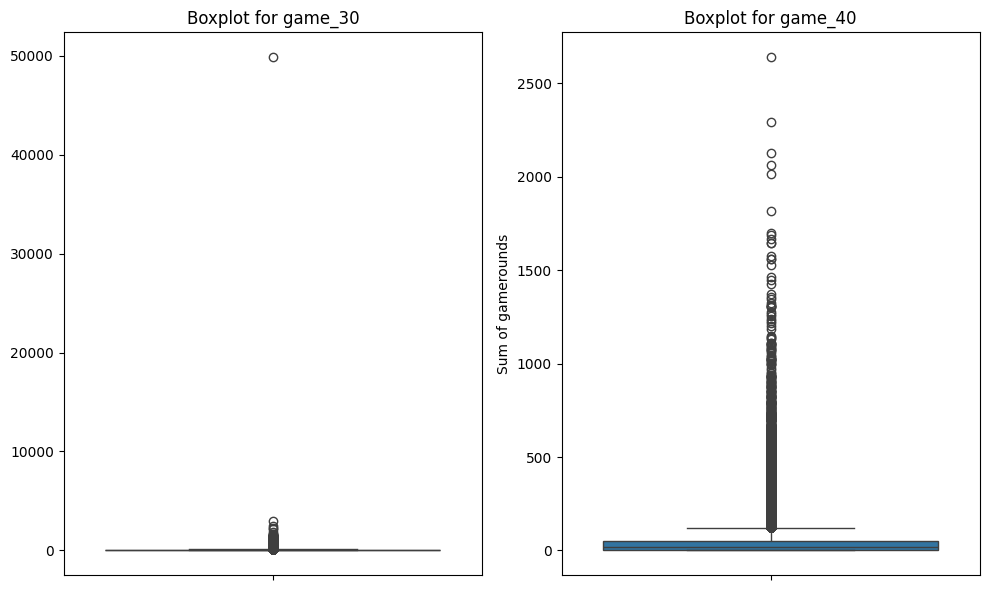

In [9]:
plt.figure(figsize=(10, 6))

# Plot the boxplot for the two groups for identifying the outliers
plt.subplot(1, 2, 1)
sns.boxplot(y=game_30)
plt.title("Boxplot for game_30")
plt.subplot(1, 2, 2)
sns.boxplot(y=game_40)
plt.title("Boxplot for game_40")

# Add labels
plt.ylabel("Sum of gamerounds")

plt.tight_layout()
plt.show()

It is clear how the outlier from the game_30 might impacts the results of the test. By cutting off the outliers we should improve the data quality.

In [10]:
# Remove the maximum value from the game_30 array and limit those from game_40
game_30 = np.delete(game_30, np.argmax(game_30))
for i in range(len(game_40)):
    if game_40[1] > 1700:
        game_40 = np.delete(game_40, i)

# Sort the arrays to prepare for the Mann-Whitney U test
game_30 = np.sort(game_30)
game_40 = np.sort(game_40)

print(f"Number of game_30 is {len(game_30)}, number of game_40 is {len(game_40)}")

Number of game_30 is 44699, number of game_40 is 45489


A slight difference in the samples size is noticed, but considering that this impacts only the 2% of the all population, it can be disregarded.

The reason for such difference can be various like natural fluctuation of users or experiment expoure.

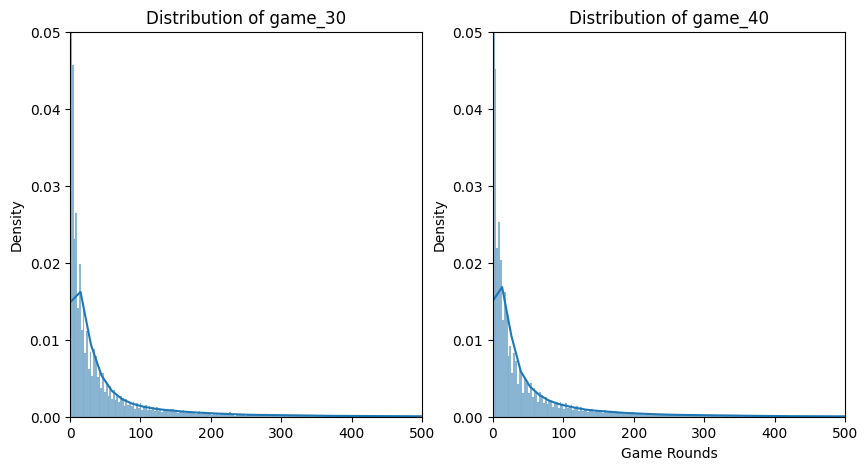

In [11]:
plt.figure(figsize=(10, 5))

# Plot the distribution of the two groups
plt.subplot(1, 2, 1)
sns.histplot(game_30, kde=True, stat="density", common_norm=False)
plt.title("Distribution of game_30")

# Set a limite for the x-axis and y-axis
plt.xlim(0, 500)
plt.ylim(0, 0.05)

plt.subplot(1, 2, 2)
sns.histplot(game_40, kde=True, stat="density", common_norm=False)
plt.title("Distribution of game_40")

# Set a limite for the x-axis and y-axis
plt.xlim(0, 500)
plt.ylim(0, 0.05)

# Add labels and title
plt.xlabel("Game Rounds")
plt.ylabel("Density")

plt.show()

From a first glance it is noticed that there is a similar distribution of game rounds regardless the version of the game. We can make the assumption though that such change does not really affect the players' usage, scenario represented by the null hypothesis.

## A/B Testing

 

### Games rounds testing - Ordinal variable

As previously mentioned, due to the distibution not being Normal, a non-paramentric will be used. 
Precisely, the Mann-Whitney U test will verify if the sample A and sample B are originated by the same population. 

In [12]:
# Run the Mann-Whitney U test
stat, p_value = mannwhitneyu(
    cookie.loc[cookie["version"] == "gate_30"]["sum_gamerounds"],
    cookie.loc[cookie["version"] == "gate_40"]["sum_gamerounds"],
)
print(f"Mann-Whitney U statistic: {stat}, p-value: {p_value}")
print(
    "Total sum of rounds for gate_30:",
    cookie.loc[cookie["version"] == "gate_30"]["sum_gamerounds"].sum(),
)
print(
    "Total sum of rounds for gate_40:",
    cookie.loc[cookie["version"] == "gate_40"]["sum_gamerounds"].sum(),
)

Mann-Whitney U statistic: 1024331250.5, p-value: 0.05020880772044255
Total sum of rounds for gate_30: 2344795
Total sum of rounds for gate_40: 2333530


Due to the distribution not being normal, we cannot use tha classic method to calculate the confidence interval, instead we will proceed with the Bootstrap method.

In [13]:
subset_30 = cookie.loc[cookie["version"] == "gate_30", "sum_gamerounds"].dropna()
subset_40 = cookie.loc[cookie["version"] == "gate_40", "sum_gamerounds"].dropna()
subset = [subset_30, subset_40]

for i in range(len(subset)):
    # Optional: Downsample
    if len(subset[i]) > 10000:
        subset[i] = subset[i].sample(n=10000, random_state=42)

    # Convert to float32 (save memory)
    subset[i] = subset[i].astype("float32")

    # Bootstrap with fewer resamples and percentile method
    result = bootstrap(
        (subset[i].values,),
        np.mean,
        confidence_level=0.95,
        method="percentile",  # lighter
        n_resamples=1000,
        random_state=42,
    )

    ci = result.confidence_interval
    print(f"95% CI: ({ci.low}, {ci.high})")

95% CI: (48.88469314575195, 52.78450393676758)
95% CI: (50.80189895629883, 54.708465576171875)


The Mann-Whitney U statistic counts how many times the values from group A precede those from group B: the bigger the statistic, the bigger the difference between the two groups. 
The highest statistic value possible is given by the product of the two samples' sizes, in our case 1,988,613,811.

Since the Mann-Whitney U test returns a statistic close to the maximum, as well as a p-value bigger than 0.05 we can conclude that the sum of rounds is not affected by the game version.

Given that, it is noticed that gate_30 counts a bigger number of rounds.

### Retention testing - Categorical data

Due to its data type, the retention will be studied with a Chi-square test.

Chi-square analysis is applied to categorical variables and is especially useful when those variables are nominal (where order doesn’t matter, like marital status or gender).

A Chi-square (χ2) statistic is a measure of the difference between the observed and expected frequencies of the outcomes of a set of events or variables. This will help us to determine if the observed results are in line with expected results.

In [14]:
# Create the contingency table for retention_1 and retention_7
table = pd.crosstab(cookie["version"], cookie["retention_1"])

# Display the table
print(table)

# Chi2_contingengy test of independence of variables in a contingency table
test = chi2_contingency(table)

# Display the test results
print(f"Chi-squared statistic: {test[0]}, p-value: {test[1]}")

retention_1  False  True 
version                  
gate_30      24666  20034
gate_40      25370  20119
Chi-squared statistic: 3.1591007878782262, p-value: 0.07550476210309086


Both the Chi-squared statistic and p-value show that there likely no dependency between the two versions of the game.

In [15]:
# Create the contingency table for retention_1 and retention_7
table = pd.crosstab(cookie["version"], cookie["retention_7"])

# Display the table
print(table)

# Chi2_contingengy test of independence of variables in a contingency table
test = chi2_contingency(table)

# Display the test results
print(f"Chi-squared statistic: {test[0]}, p-value: {test[1]}")

retention_7  False  True 
version                  
gate_30      36198   8502
gate_40      37210   8279
Chi-squared statistic: 9.959086799559167, p-value: 0.0016005742679058301


In this case though, the p-value is rather low, and the Chi-square statistic high, meaning that we can reject the null hypothesis for the what concerns the gate version.

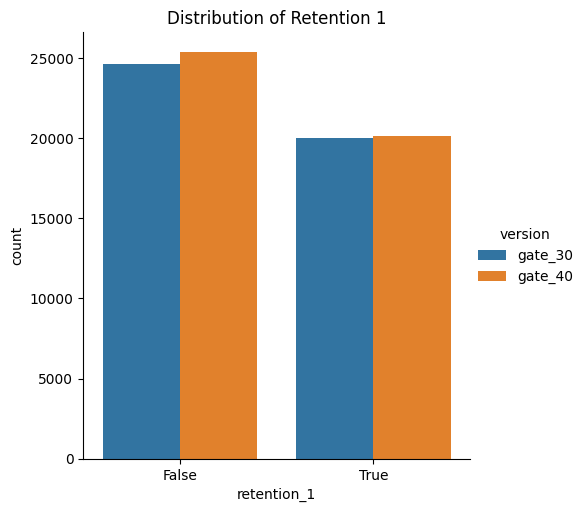

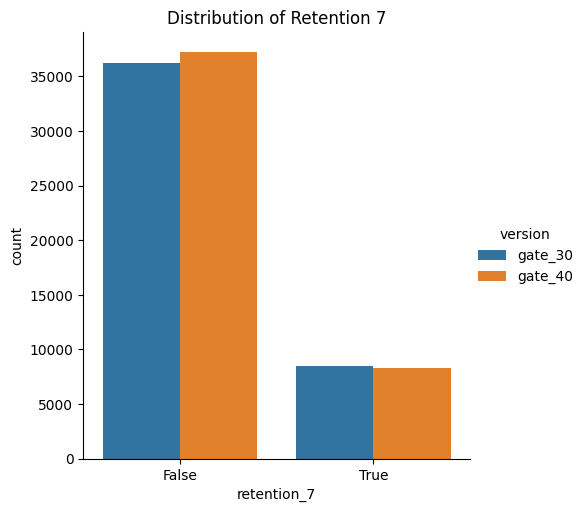

In [16]:
# Plot the distribution of retention_1
sns.catplot(data=cookie, x=cookie["retention_1"], kind="count", hue=cookie["version"])
# Set title, labels and legend
plt.title("Distribution of Retention 1")


# Plot the distribution of retention_7
sns.catplot(data=cookie, x=cookie["retention_7"], kind="count", hue=cookie["version"])
# Set title, labels and legend
plt.title("Distribution of Retention 7")


# Show the plots
plt.show()

The two barplots above show the distribution of retention for both the game versions, where we can see a sensible reduction of players after 7 days

## Conclusions


By completing the test, it is possible to make the following conclusions:
- "sum_gamerounds" and "retention_1" are the two metrics where the null hypothesis is rejected, hence any marketing-related decision should be based on these two metrics
- Statistically, there is a difference between gate_30 and gate_40, with the second involving slightly less player for less time. Overall though, this seems not to have a significant weight when it comes to real effects.
- The analysis is limited to these two metrics, but in a real scenario it should be useful to compare the amount of resources used against the actual revenue generated by the moving the gate to another level
-  For a better context, it would be interesting to review how the test was engineering and the data collected